## GCP-based Multi-Label Movie Plot Classifier by Xiran Li


### 1) Data Exploration


#### a. Read the movie synopsis data into Spark 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#create Spark session
spark = SparkSession.builder.appName('MovieML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#remove the limit of broadcast size
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [34]:
df = spark.read.option("multiLine", "true") \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("gs://msca_bdp_xiranli/mpst_full_data.csv",inferSchema=True, header=True )

In [35]:
df.show(30)

+---------+--------------------+--------------------+--------------------+-----+---------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|
+---------+--------------------+--------------------+--------------------+-----+---------------+
|tt0057603|I tre volti della...|Note: this synops...|cult, horror, got...|train|           imdb|
|tt1733125|Dungeons & Dragon...|Two thousand year...|            violence|train|           imdb|
|tt0033045|The Shop Around t...|Matuschek's, a gi...|            romantic| test|           imdb|
|tt0113862|  Mr. Holland's Opus|Glenn Holland, no...|inspiring, romant...|train|           imdb|
|tt0086250|            Scarface|In May 1980, a Cu...|cruelty, murder, ...|  val|           imdb|
|tt1315981|        A Single Man|George Falconer (...|romantic, queer, ...|  val|           imdb|
|tt0249380|           Baise-moi|Baise-moi tells t...|gothic, cruelty, ...|train|      wikipedia|
|tt0408790|          Flightpla

Repartition

In [5]:
df.rdd.getNumPartitions()

1

In [6]:
sc.getConf().get("spark.executor.cores")

'4'

In [4]:
# The general recommendation for Spark is to have 4x of partitions to the number of cores in cluster available for application
df = df.repartition(16)

In [8]:
df.rdd.getNumPartitions()

16

In [5]:
# Check the foramt of input data
from pyspark.sql.functions import col
# Check if there are wrong lines
df.where(~col('imdb_id').like("tt%")).count()  

0

In [6]:
# For safe, still try to drop the rows with messy data
df = df.where(col('imdb_id').like("tt%"))

In [12]:
df.show()

+---------+--------------------+--------------------+--------------------+-----+---------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|
+---------+--------------------+--------------------+--------------------+-----+---------------+
|tt0124879|         Simon Birch|Simon Birch belie...|dramatic, philoso...|train|      wikipedia|
|tt0119547|     Little Boy Blue|Living in the bac...|murder, violence,...|train|      wikipedia|
|tt0044744|The Importance of...|The play is set i...|            romantic| test|      wikipedia|
|tt0148375|             Khilona|Vijaykamal (Sanje...|  insanity, romantic| test|      wikipedia|
|tt0414078|  Halloweentown High|Two years after t...|              horror|train|      wikipedia|
|tt0947802|    Lakeview Terrace|In California, Ab...|dramatic, violenc...| test|           imdb|
|tt0048127|  Gojira no gyakushû|Two pilots named ...|                cult|train|      wikipedia|
|tt0047196|  Lumber Jack-Rabbi

#### b. Print basic summary statistics of the data set 


In [7]:
df.printSchema()

root
 |-- imdb_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- split: string (nullable = true)
 |-- synopsis_source: string (nullable = true)



In [22]:
df.describe().show()

+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+
|summary|  imdb_id|            title|            plot_synopsis|                tags|split|synopsis_source|
+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+
|  count|    14828|            14828|                    14828|                3867| 3867|           3867|
|   mean|     null|615.7078947368421|                     null|                null| null|           null|
| stddev|     null|820.9172438097585|                     null|                null| null|           null|
|    min|tt0000091|                $|     ".hack//Roots" fo...|              absurd| test|           imdb|
|    max|tt6583664|        Üç Maymun|《龍虎門》Dragon Tiger...|whimsical, though...|  val|      wikipedia|
+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+



In [7]:
# Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+-------+-----+-------------+----+-----+---------------+
|imdb_id|title|plot_synopsis|tags|split|synopsis_source|
+-------+-----+-------------+----+-----+---------------+
|      0|    0|            0|   0|    0|              0|
+-------+-----+-------------+----+-----+---------------+



In [8]:
df.groupby('split').count().show()

+-----+-----+
|split|count|
+-----+-----+
|train| 2484|
| test|  776|
|  val|  607|
+-----+-----+



In [9]:
df.groupby('synopsis_source').count().show()

+---------------+-----+
|synopsis_source|count|
+---------------+-----+
|           imdb| 3498|
|      wikipedia|  369|
+---------------+-----+



#### c. Create a horizontal bar chart of movie tag counts such as action, cult, horror, etc.


In [7]:
# Split the "tags" column by a comma followed by a space, and then explode the resulting array into multiple rows.
from pyspark.sql.functions import explode, split
df = df.withColumn('tags_split', explode(split('tags', ', ')))

In [8]:
df.show()

+---------+--------------------+--------------------+--------------------+-----+---------------+-------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|   tags_split|
+---------+--------------------+--------------------+--------------------+-----+---------------+-------------+
|tt0124879|         Simon Birch|Simon Birch belie...|dramatic, philoso...|train|      wikipedia|     dramatic|
|tt0124879|         Simon Birch|Simon Birch belie...|dramatic, philoso...|train|      wikipedia|philosophical|
|tt0124879|         Simon Birch|Simon Birch belie...|dramatic, philoso...|train|      wikipedia|  sentimental|
|tt0119547|     Little Boy Blue|Living in the bac...|murder, violence,...|train|      wikipedia|       murder|
|tt0119547|     Little Boy Blue|Living in the bac...|murder, violence,...|train|      wikipedia|     violence|
|tt0119547|     Little Boy Blue|Living in the bac...|murder, violence,...|train|      wikipedia|       sadist|
|

In [15]:
df1 = df.groupby('tags_split').count().orderBy('count', ascending = [0])

In [16]:
df1.show(20)

+----------------+-----+
|      tags_split|count|
+----------------+-----+
|          murder| 5782|
|        violence| 4426|
|       flashback| 2937|
|        romantic| 2906|
|            cult| 2647|
|         revenge| 2468|
|     psychedelic| 1897|
|          comedy| 1859|
|     suspenseful| 1086|
|good versus evil|  875|
|           humor|  822|
|          satire|  816|
|    entertaining|  749|
|        neo noir|  745|
|          action|  664|
|          sadist|  652|
|        insanity|  636|
|         tragedy|  597|
|         fantasy|  564|
|      paranormal|  546|
+----------------+-----+
only showing top 20 rows



In [17]:
pdf1 = df1.toPandas()

<AxesSubplot:ylabel='tags_split'>

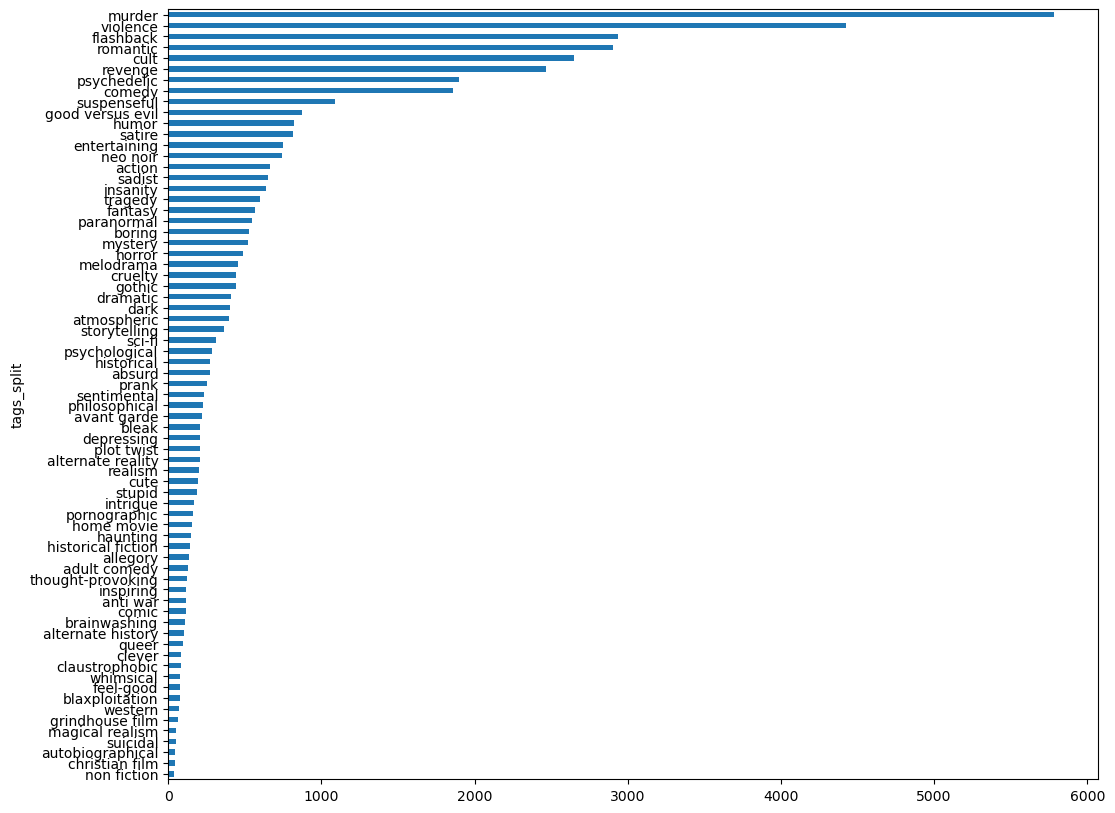

In [35]:
pdf1.sort_values(by='count').plot(kind="barh", x="tags_split", y="count", legend=False, figsize = (12, 10))

#### d. Arrange bar in descending order and identify the top 10 popular tags

The top 10 popular tags are murder, violence, flashback, romantic, cult, revenge, psychedelic, comedy, suspenseful and good versus evil.

<AxesSubplot:xlabel='tags_split'>

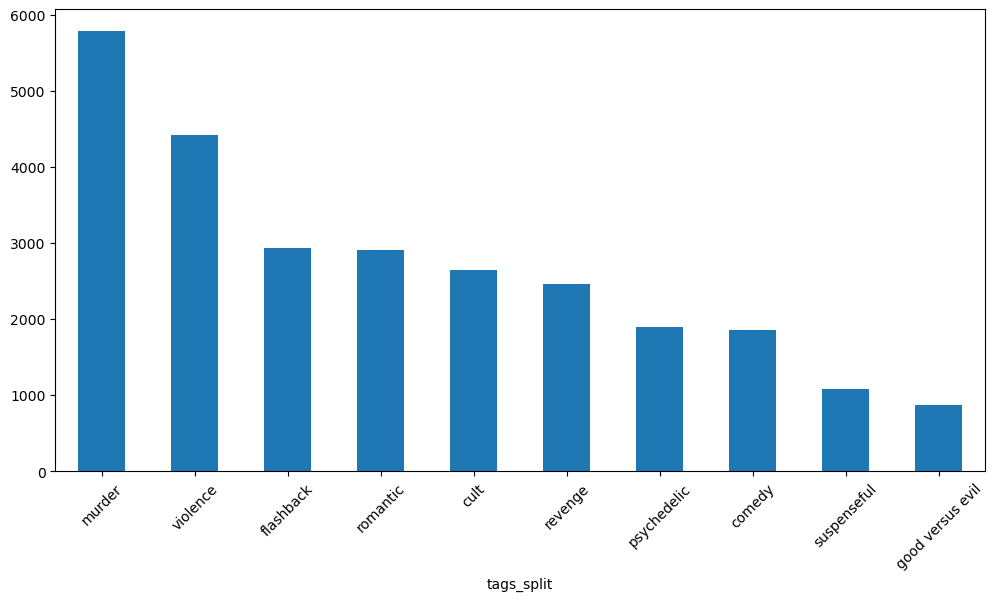

In [25]:
pdf1.head(10).plot(kind="bar", x="tags_split", y="count", legend=False, figsize = (12, 6), rot = 45)

### 2) Machine Learning Models 

In [8]:
#spark ML imports
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, StringIndexer, CountVectorizer, Word2Vec
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#### a. Use a SparkML pipeline to build models to classify movies into the top 10 most popular tags.

#### b. The NLP pipeline should include removal of stopwords and tokenization of the syopsis data

In [9]:
tokenizer = Tokenizer(inputCol = 'plot_synopsis', outputCol = 'words')
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

#### c. The NLP pipeline should include more than one vectorization methods on the synopsis text for comparison (e.g. Count Vectorization, HashingTF, TF-IDF, BERT, etc.)


##### Method 1：HashingTF

In [33]:
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")

In [60]:
pipeline1 = Pipeline(stages = [tokenizer, remover, hashingTF])
pipeline_model1 = pipeline1.fit(df) # For future transform inference data
encodedData1 = pipeline_model1.transform(df)

In [27]:
encodedData1 = encodedData1.select('plot_synopsis', 'features', 'split', 'tags_split')
encodedData1.show()

+--------------------+--------------------+-----+----------------+
|       plot_synopsis|            features|split|      tags_split|
+--------------------+--------------------+-----+----------------+
|Retired police de...|(262144,[2977,385...|train|        insanity|
|Retired police de...|(262144,[2977,385...|train|         mystery|
|Retired police de...|(262144,[2977,385...|train|          murder|
|Retired police de...|(262144,[2977,385...|train|     sentimental|
|The play opens wi...|(262144,[1277,230...|  val|         revenge|
|The play opens wi...|(262144,[1277,230...|  val|        romantic|
|The play opens wi...|(262144,[1277,230...|  val|       flashback|
|12-year-old boys ...|(262144,[7862,912...|train|        violence|
|12-year-old boys ...|(262144,[7862,912...|train|           prank|
|Newly weds Dick (...|(262144,[1765,241...|train|        violence|
|Newly weds Dick (...|(262144,[1765,241...|train|        neo noir|
|Newly weds Dick (...|(262144,[1765,241...|train|          mur

##### Method 2：Word2Vec

In [75]:
word2vec = Word2Vec(inputCol=remover.getOutputCol(), outputCol="features")

In [76]:
pipeline2 = Pipeline(stages = [tokenizer, remover, word2vec])
pipeline_model2 = pipeline2.fit(df)
encodedData2 = pipeline_model2.transform(df)

23/08/12 04:12:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/08/12 04:12:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [31]:
encodedData2 = encodedData2.select('plot_synopsis', 'features', 'split', 'tags_split')
encodedData2.show()

+--------------------+--------------------+-----+----------------+
|       plot_synopsis|            features|split|      tags_split|
+--------------------+--------------------+-----+----------------+
|Retired police de...|[0.04260323591518...|train|        insanity|
|Retired police de...|[0.04260323591518...|train|         mystery|
|Retired police de...|[0.04260323591518...|train|          murder|
|Retired police de...|[0.04260323591518...|train|     sentimental|
|The play opens wi...|[0.04796001074155...|  val|         revenge|
|The play opens wi...|[0.04796001074155...|  val|        romantic|
|The play opens wi...|[0.04796001074155...|  val|       flashback|
|12-year-old boys ...|[0.05646870708386...|train|        violence|
|12-year-old boys ...|[0.05646870708386...|train|           prank|
|Newly weds Dick (...|[0.06081596674096...|train|        violence|
|Newly weds Dick (...|[0.06081596674096...|train|        neo noir|
|Newly weds Dick (...|[0.06081596674096...|train|          mur

##### Method 3: Count Vectorizer

In [10]:
countVectorizer = CountVectorizer(inputCol = remover.getOutputCol(), outputCol = 'features')

In [11]:
pipeline3 = Pipeline(stages = [tokenizer, remover, countVectorizer])
pipeline_model3 = pipeline3.fit(df)
encodedData3 = pipeline_model3.transform(df)

In [12]:
encodedData3 = encodedData3.select('plot_synopsis', 'features', 'split', 'tags_split')
encodedData3.show()

23/08/12 05:19:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB


+--------------------+--------------------+-----+----------------+
|       plot_synopsis|            features|split|      tags_split|
+--------------------+--------------------+-----+----------------+
|Retired police de...|(262144,[0,1,4,7,...|train|        insanity|
|Retired police de...|(262144,[0,1,4,7,...|train|         mystery|
|Retired police de...|(262144,[0,1,4,7,...|train|          murder|
|Retired police de...|(262144,[0,1,4,7,...|train|     sentimental|
|The play opens wi...|(262144,[0,3,5,6,...|  val|         revenge|
|The play opens wi...|(262144,[0,3,5,6,...|  val|        romantic|
|The play opens wi...|(262144,[0,3,5,6,...|  val|       flashback|
|12-year-old boys ...|(262144,[1,2,3,4,...|train|        violence|
|12-year-old boys ...|(262144,[1,2,3,4,...|train|           prank|
|Newly weds Dick (...|(262144,[1,2,3,5,...|train|        violence|
|Newly weds Dick (...|(262144,[1,2,3,5,...|train|        neo noir|
|Newly weds Dick (...|(262144,[1,2,3,5,...|train|          mur

#### d. Pivot the data such that you are able to train one model for each genre tag.


In [14]:
selected_tags = ['murder', 'violence', 'flashback', 'romantic', 'cult', 'revenge', 'psychedelic', 'comedy', 'suspenseful', 'good versus evil']
pivot_df1 = encodedData1.groupby('plot_synopsis', 'features', 'split').pivot('tags_split', selected_tags).count().fillna(0)

In [33]:
pivot_df1.show(10)

+--------------------+--------------------+-----+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|       plot_synopsis|            features|split|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+--------------------+-----+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|The film opens wi...|(262144,[619,1165...|train|     1|       0|        0|       1|   0|      0|          0|     1|          0|               0|
|Alex Hartdegen is...|(262144,[389,1232...|train|     1|       0|        0|       0|   0|      0|          0|     0|          1|               0|
|In 2071, roughly ...|(262144,[1414,437...|  val|     1|       1|        1|       0|   0|      0|          1|     1|          0|               1|
|The Ozunu Clan, l...|(262144,[2215,230...|train|     1|       1|        1|       0|   0|      1|          0|     0|        

In [16]:
# Pivot encodedData2 and encodedData3 
pivot_df2 = encodedData2.groupby('plot_synopsis', 'features', 'split').pivot('tags_split', selected_tags).count().fillna(0)
pivot_df3 = encodedData3.groupby('plot_synopsis', 'features', 'split').pivot('tags_split', selected_tags).count().fillna(0)

#### e. The model should take in the movie synposis text as input features and individual tags as labels. Use the existing column “split” to split the data into train and test.

In [36]:
train_df1 = pivot_df1.where(col('split') == 'train').drop('plot_synopsis', 'split')
test_df1 = pivot_df1.where(col('split') == 'test').drop('plot_synopsis', 'split')
val_df1 = pivot_df1.where(col('split') == 'val').drop('plot_synopsis', 'split')

In [ ]:
train_df1.show(5)

+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|            features|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|(262144,[3866,503...|     1|       0|        0|       0|   1|      0|          0|     0|          0|               0|
|(262144,[389,1232...|     1|       0|        0|       0|   0|      0|          0|     0|          1|               0|
|(262144,[956,1074...|     1|       1|        0|       0|   1|      0|          0|     0|          0|               0|
|(262144,[2215,230...|     1|       1|        1|       0|   0|      1|          0|     0|          0|               1|
|(262144,[640,779,...|     1|       0|        1|       0|   1|      0|          0|     0|          0|               0|
+--------------------+------+--------+---------+

In [38]:
train_df2 = pivot_df2.where(col('split') == 'train').drop('plot_synopsis', 'split')
test_df2 = pivot_df2.where(col('split') == 'test').drop('plot_synopsis', 'split')
val_df2 = pivot_df2.where(col('split') == 'val').drop('plot_synopsis', 'split')

In [40]:
train_df2.show()

+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|            features|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|[0.02669467546942...|     0|       1|        1|       1|   0|      0|          0|     1|          0|               0|
|[0.07532853098586...|     0|       0|        0|       0|   0|      0|          0|     0|          0|               0|
|[0.08520935153460...|     0|       0|        0|       0|   0|      0|          0|     1|          0|               0|
|[0.03672997310746...|     1|       0|        1|       0|   0|      0|          0|     0|          0|               0|
|[0.05813089712452...|     1|       1|        1|       0|   1|      1|          0|     1|          0|               0|
|[0.06528311976842...|     1|       1|        1|

In [17]:
train_df3 = pivot_df3.where(col('split') == 'train').drop('plot_synopsis', 'split')
test_df3 = pivot_df3.where(col('split') == 'test').drop('plot_synopsis', 'split')
val_df3 = pivot_df3.where(col('split') == 'val').drop('plot_synopsis', 'split')

#### f. If you use a One vs Rest classification approach to build your model, display validation scores against models for each of the 10 tags. Your final output should be a table with tag, f1 and accuracy. You should have 3 columns and 10 rows.


In [41]:
# Model 1 using train_df1 & test_df1
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

model1 = {}
results1 = {}

for tag in selected_tags:
    
    lgr = LogisticRegression(maxIter = 10, featuresCol = 'features', labelCol = tag)
    
    lgrm = lgr.fit(train_df1)
    
    model1[tag] = lgrm
    
    model_path1 = f"gs://msca_bdp_xiranli/Model/model1_{tag}"
    
    lgrm.save(model_path1)
    
    predictions = lgrm.transform(test_df1)
    
    evaluator = MulticlassClassificationEvaluator(labelCol= tag , predictionCol="prediction")
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

    F1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    results1[tag] = [accuracy, F1]

23/08/12 02:13:34 WARN org.apache.spark.scheduler.TaskSetManager: Stage 212 contains a task of very large size (12545 KiB). The maximum recommended task size is 1000 KiB.
23/08/12 02:13:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.1 MiB
23/08/12 02:13:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.1 MiB
23/08/12 02:15:58 WARN org.apache.spark.scheduler.TaskSetManager: Stage 321 contains a task of very large size (16725 KiB). The maximum recommended task size is 1000 KiB.
23/08/12 02:16:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 16.1 MiB
23/08/12 02:16:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 16.1 MiB
23/08/12 02:17:38 WARN org.apache.spark.scheduler.TaskSetManager: Stage 430 contains a task of very large size (6274 KiB). The maximum recommended task size is 1000 KiB.
23/08/12 02:17:47 WARN org.apach

In [42]:
output1 = []

for tag in selected_tags:
    
    model_name = tag
    
    accuracy = round(results1[tag][1], 4)
    
    F1 = round(results1[tag][0], 4)
    
    output1.append([model_name, accuracy, F1])

output_df1 = spark.createDataFrame(output1, ['model_name', 'accuracy', 'F1'])

In [43]:
output_df1.show()

+----------------+--------+------+
|      model_name|accuracy|    F1|
+----------------+--------+------+
|          murder|   0.661|0.6759|
|        violence|  0.6977|0.7219|
|       flashback|  0.7157| 0.771|
|        romantic|  0.7518|0.7899|
|            cult|  0.7449|0.7916|
|         revenge|  0.7607|0.8016|
|     psychedelic|  0.8332| 0.862|
|          comedy|  0.8178| 0.862|
|     suspenseful|  0.8832|0.9114|
|good versus evil|  0.9144|0.9334|
+----------------+--------+------+



In [44]:
# Model 2 using train_df2 & test_df2
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

model2 = {}
results2 = {}

for tag in selected_tags:
    
    lgr = LogisticRegression(maxIter = 10, featuresCol = 'features', labelCol = tag)
    
    lgrm = lgr.fit(train_df2)
    
    model2[tag] = lgrm
    
    model_path2 = f"gs://msca_bdp_xiranli/Model/model2_{tag}"
    
    lgrm.save(model_path2)
    
    predictions = lgrm.transform(test_df2)
    
    evaluator = MulticlassClassificationEvaluator(labelCol= tag , predictionCol="prediction")
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

    F1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    results2[tag] = [accuracy, F1]

In [45]:
output2 = []

for tag in selected_tags:
    
    model_name = tag
    
    accuracy = round(results2[tag][1], 4)
    
    F1 = round(results2[tag][0], 4)
    
    output2.append([model_name, accuracy, F1])

output_df2 = spark.createDataFrame(output2, ['model_name', 'accuracy', 'F1'])

In [46]:
output_df2.show()

+----------------+--------+------+
|      model_name|accuracy|    F1|
+----------------+--------+------+
|          murder|  0.7012|0.7075|
|        violence|  0.7437|  0.76|
|       flashback|  0.7102|0.7916|
|        romantic|  0.7637| 0.806|
|            cult|  0.7388|0.8088|
|         revenge|  0.7697|0.8208|
|     psychedelic|  0.8336| 0.873|
|          comedy|  0.8204|0.8747|
|     suspenseful|  0.8911|0.9224|
|good versus evil|  0.9188|0.9334|
+----------------+--------+------+



In [ ]:
# Model 3 using train_df3 & test_df3
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

model3 = {}
results3 = {}

for tag in selected_tags:
    
    lgr = LogisticRegression(maxIter = 10, featuresCol = 'features', labelCol = tag)
    
    lgrm = lgr.fit(train_df3)
    
    model3[tag] = lgrm
    
    model_path3 = f"gs://msca_bdp_xiranli/Model/model3_{tag}"
    
    lgrm.save(model_path3)
    
    predictions = lgrm.transform(test_df3)
    
    evaluator = MulticlassClassificationEvaluator(labelCol= tag , predictionCol="prediction")
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

    F1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    results3[tag] = [accuracy, F1]

23/08/12 05:21:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/12 05:21:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/12 05:21:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/08/12 05:21:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/12 05:21:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/12 05:21:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/08/12 05:21:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/08/12 05:21:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/08/12 05:21:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

In [20]:
output3 = []

for tag in selected_tags:
    
    model_name = tag
    
    accuracy = round(results3[tag][1], 4)
    
    F1 = round(results3[tag][0], 4)
    
    output3.append([model_name, accuracy, F1])

output_df3 = spark.createDataFrame(output3, ['model_name', 'accuracy', 'F1'])

In [21]:
output_df3.show()

+----------------+--------+------+
|      model_name|accuracy|    F1|
+----------------+--------+------+
|          murder|  0.6627|0.6825|
|        violence|  0.6928|0.7302|
|       flashback|  0.7081|0.7748|
|        romantic|  0.7521|0.7927|
|            cult|  0.7348|0.7978|
|         revenge|  0.7646|0.8153|
|     psychedelic|  0.8296|0.8654|
|          comedy|  0.8195|0.8668|
|     suspenseful|  0.8833|0.9145|
|good versus evil|  0.9156|0.9351|
+----------------+--------+------+



### 3) Inference 

Collect synopsis data for at least 10 recent movies (e.g., 2020 until today) from any public source. Using the NLP models created above ,identify which of the 10 popular tags apply to these movies. Note: if none of the top 10 tags apply to your movies, explain why and investigate if the model can be further improved to generalize better.

In [23]:
Inference_movie = spark.read.option("multiLine", "true") \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("gs://msca_bdp_xiranli/Inference_movie.csv", inferSchema=True, header=True)

In [24]:
Inference_movie.show()

+--------------------+----+--------------------+
|                Name|Year|       plot_synopsis|
+--------------------+----+--------------------+
|         Oppenheimer|2023|In 1926, 22-year-...|
|              Barbie|2023|Stereotypical Bar...|
|Guardians of the ...|2023|At their new head...|
|Teenage Mutant Ni...|2023|Techno Cosmic Res...|
|          Talk to Me|2022|A young man, Cole...|
|   Meg 2: The Trench|2023|Five years after ...|
|Mission: Impossib...|2023|The next-generati...|
|    Sound of Freedom|2023|In Tegucigalpa, H...|
|       Hidden Strike|2023|After an oil refi...|
|Everything Everyw...|2022|Evelyn Quan Wang ...|
+--------------------+----+--------------------+



In [45]:
Inference_movie.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- plot_synopsis: string (nullable = true)



In [61]:
df_inference1 = pipeline_model1.transform(Inference_movie)

In [62]:
df_inference1.show()

+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|                Name|Year|       plot_synopsis|               words|            filtered|            features|
+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|         Oppenheimer|2023|In 1926, 22-year-...|[in, 1926,, 22-ye...|[1926,, 22-year-o...|(262144,[462,1354...|
|              Barbie|2023|Stereotypical Bar...|[stereotypical, b...|[stereotypical, b...|(262144,[1004,192...|
|Guardians of the ...|2023|At their new head...|[at, their, new, ...|[new, headquarter...|(262144,[3176,356...|
|Teenage Mutant Ni...|2023|Techno Cosmic Res...|[techno, cosmic, ...|[techno, cosmic, ...|(262144,[810,2679...|
|          Talk to Me|2022|A young man, Cole...|[a, young, man,, ...|[young, man,, col...|(262144,[134,321,...|
|   Meg 2: The Trench|2023|Five years after ...|[five, years, aft...|[five, years, eve...|(262144,[3475,

In [78]:
df_inference2 = pipeline_model2.transform(Inference_movie)

In [79]:
df_inference2.show()

+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|                Name|Year|       plot_synopsis|               words|            filtered|            features|
+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|         Oppenheimer|2023|In 1926, 22-year-...|[in, 1926,, 22-ye...|[1926,, 22-year-o...|[0.02672793405977...|
|              Barbie|2023|Stereotypical Bar...|[stereotypical, b...|[stereotypical, b...|[0.02103143126163...|
|Guardians of the ...|2023|At their new head...|[at, their, new, ...|[new, headquarter...|[0.00532854519296...|
|Teenage Mutant Ni...|2023|Techno Cosmic Res...|[techno, cosmic, ...|[techno, cosmic, ...|[0.04986294124052...|
|          Talk to Me|2022|A young man, Cole...|[a, young, man,, ...|[young, man,, col...|[-0.0170522234076...|
|   Meg 2: The Trench|2023|Five years after ...|[five, years, aft...|[five, years, eve...|[-0.0083264046

In [25]:
df_inference3 = pipeline_model3.transform(Inference_movie)

In [26]:
df_inference3.show()

23/08/12 07:11:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB


+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|                Name|Year|       plot_synopsis|               words|            filtered|            features|
+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|         Oppenheimer|2023|In 1926, 22-year-...|[in, 1926,, 22-ye...|[1926,, 22-year-o...|(262144,[1,4,15,1...|
|              Barbie|2023|Stereotypical Bar...|[stereotypical, b...|[stereotypical, b...|(262144,[0,3,5,10...|
|Guardians of the ...|2023|At their new head...|[at, their, new, ...|[new, headquarter...|(262144,[0,1,4,10...|
|Teenage Mutant Ni...|2023|Techno Cosmic Res...|[techno, cosmic, ...|[techno, cosmic, ...|(262144,[2,11,16,...|
|          Talk to Me|2022|A young man, Cole...|[a, young, man,, ...|[young, man,, col...|(262144,[0,1,2,4,...|
|   Meg 2: The Trench|2023|Five years after ...|[five, years, aft...|[five, years, eve...|(262144,[1,3,1

In [63]:
df_inference1 = df_inference1.select('Name', 'Year', 'plot_synopsis', 'features')

In [80]:
df_inference2 = df_inference2.select('Name', 'Year', 'plot_synopsis', 'features')

In [27]:
df_inference3 = df_inference3.select('Name', 'Year', 'plot_synopsis', 'features')

In [54]:
df_inference1.show(10)

+--------------------+----+--------------------+--------------------+
|                Name|Year|       plot_synopsis|            features|
+--------------------+----+--------------------+--------------------+
|         Oppenheimer|2023|In 1926, 22-year-...|(262144,[462,1354...|
|              Barbie|2023|Stereotypical Bar...|(262144,[1004,192...|
|Guardians of the ...|2023|At their new head...|(262144,[3176,356...|
|Teenage Mutant Ni...|2023|Techno Cosmic Res...|(262144,[810,2679...|
|          Talk to Me|2022|A young man, Cole...|(262144,[134,321,...|
|   Meg 2: The Trench|2023|Five years after ...|(262144,[3475,366...|
|Mission: Impossib...|2023|The next-generati...|(262144,[2437,297...|
|    Sound of Freedom|2023|In Tegucigalpa, H...|(262144,[528,619,...|
|       Hidden Strike|2023|After an oil refi...|(262144,[2731,356...|
|Everything Everyw...|2022|Evelyn Quan Wang ...|(262144,[372,2564...|
+--------------------+----+--------------------+--------------------+



In [50]:
# Use Model 1 to predict inference data
from pyspark.ml.classification import LogisticRegressionModel
loaded_models1 = {}

for tag in selected_tags:
    model_path1 = f"gs://msca_bdp_xiranli/Model/model1_{tag}"
    loaded_model1 = LogisticRegressionModel.load(model_path1)
    loaded_models1[tag] = loaded_model1

In [64]:
# Save predictions for each tag
predictions_dict1 = {}

for tag in selected_tags:
    
    inference_predictions1 = loaded_models1[tag].transform(df_inference1)
    
    inference_predictions1 = inference_predictions1.select('Name', 'prediction').withColumnRenamed('prediction', tag)
    
    predictions_dict1[tag] = inference_predictions1

In [65]:
#Self join each tag's prediction to output the final result
base_df_name1 = list(predictions_dict1.keys())[0]
base_df1 = predictions_dict1[base_df_name1]

for tag, temp_df in predictions_dict1.items():
    if tag != base_df_name1:
        base_df1 = base_df1.join(temp_df, on="Name", how="inner")

In [66]:
base_df1.show()

23/08/12 03:51:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 16.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 03:51:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bina

+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|                Name|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|              Barbie|   0.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Everything Everyw...|   0.0|     0.0|      0.0|     1.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|   Meg 2: The Trench|   0.0|     0.0|      0.0|     0.0| 0.0|    1.0|        0.0|   0.0|        0.0|             0.0|
|Teenage Mutant Ni...|   0.0|     1.0|      0.0|     0.0| 0.0|    0.0|        1.0|   0.0|        0.0|             0.0|
|Guardians of the ...|   1.0|     1.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Mission: Impossib...|   1.0|     1.0|      0.0|

In [81]:
# Use Model 2 to predict inference data
from pyspark.ml.classification import LogisticRegressionModel
loaded_models2 = {}

for tag in selected_tags:
    model_path2 = f"gs://msca_bdp_xiranli/Model/model2_{tag}"
    loaded_model2 = LogisticRegressionModel.load(model_path2)
    loaded_models2[tag] = loaded_model2

In [82]:
predictions_dict2 = {}

for tag in selected_tags:
    
    inference_predictions2 = loaded_models2[tag].transform(df_inference2)
    
    inference_predictions2 = inference_predictions2.select('Name', 'prediction').withColumnRenamed('prediction', tag)
    
    predictions_dict2[tag] = inference_predictions2

In [83]:
base_df_name2 = list(predictions_dict2.keys())[0]
base_df2 = predictions_dict2[base_df_name2]

for tag, temp_df in predictions_dict2.items():
    if tag != base_df_name2:
        base_df2 = base_df2.join(temp_df, on="Name", how="inner")

In [84]:
base_df2.show()

+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|                Name|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|              Barbie|   0.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Everything Everyw...|   0.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|   Meg 2: The Trench|   0.0|     1.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Teenage Mutant Ni...|   0.0|     1.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Guardians of the ...|   1.0|     1.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             1.0|
|Mission: Impossib...|   1.0|     1.0|      0.0|

In [28]:
# Use Model 3 to predict inference data
from pyspark.ml.classification import LogisticRegressionModel
loaded_models3 = {}

for tag in selected_tags:
    model_path3 = f"gs://msca_bdp_xiranli/Model/model3_{tag}"
    loaded_model3 = LogisticRegressionModel.load(model_path3)
    loaded_models3[tag] = loaded_model3

In [29]:
predictions_dict3 = {}

for tag in selected_tags:
    
    inference_predictions3 = loaded_models3[tag].transform(df_inference3)
    
    inference_predictions3 = inference_predictions3.select('Name', 'prediction').withColumnRenamed('prediction', tag)
    
    predictions_dict3[tag] = inference_predictions3

In [30]:
base_df_name3 = list(predictions_dict3.keys())[0]
base_df3 = predictions_dict3[base_df_name3]

for tag, temp_df in predictions_dict3.items():
    if tag != base_df_name3:
        base_df3 = base_df3.join(temp_df, on="Name", how="inner")

In [31]:
base_df3.show()

23/08/12 07:12:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 14.9 MiB
23/08/12 07:12:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 18.9 MiB
23/08/12 07:12:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:12:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.9 MiB
23/08/12 07:12:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:12:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.9 MiB
23/08/12 07:12:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.9 MiB
23/08/12 07:12:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:12:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bin

+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|                Name|murder|violence|flashback|romantic|cult|revenge|psychedelic|comedy|suspenseful|good versus evil|
+--------------------+------+--------+---------+--------+----+-------+-----------+------+-----------+----------------+
|              Barbie|   0.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Everything Everyw...|   0.0|     0.0|      0.0|     1.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|   Meg 2: The Trench|   0.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Teenage Mutant Ni...|   0.0|     1.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Guardians of the ...|   1.0|     0.0|      0.0|     0.0| 0.0|    0.0|        0.0|   0.0|        0.0|             0.0|
|Mission: Impossib...|   1.0|     1.0|      0.0|

In [88]:
# To generate tag list for predictions of model 1 (HashingTF)
from pyspark.sql.functions import concat_ws

tag_lists = [
    concat_ws(', ', *[
        when(col(selected_tag) == 1, selected_tag).otherwise(None)
        for selected_tag in selected_tags
    ]).alias('tags')
]

new_df1 = base_df1.select('Name', *tag_lists)

new_df1.show(truncate=False)

23/08/12 04:21:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.0 MiB
23/08/12 04:21:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 16.0 MiB
23/08/12 04:21:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 04:21:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/12 04:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 04:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/12 04:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.0 MiB
23/08/12 04:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/08/12 04:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bina

+---------------------------------------------+---------------------+
|Name                                         |tags                 |
+---------------------------------------------+---------------------+
|Barbie                                       |                     |
|Everything Everywhere All at Once            |romantic             |
|Meg 2: The Trench                            |revenge              |
|Teenage Mutant Ninja Turtles: Mutant Mayhem  |violence, psychedelic|
|Guardians of the Galaxy Vol. 3               |murder, violence     |
|Mission: Impossible - Dead Reckoning Part One|murder, violence     |
|Oppenheimer                                  |suspenseful          |
|Sound of Freedom                             |murder               |
|Talk to Me                                   |                     |
|Hidden Strike                                |violence             |
+---------------------------------------------+---------------------+



In [89]:
# To generate tag list for predictions of model 2 (Word2Vec)
from pyspark.sql.functions import concat_ws

tag_lists = [
    concat_ws(', ', *[
        when(col(selected_tag) == 1, selected_tag).otherwise(None)
        for selected_tag in selected_tags
    ]).alias('tags')
]

new_df2 = base_df2.select('Name', *tag_lists)

new_df2.show(truncate=False)

+---------------------------------------------+----------------------------------+
|Name                                         |tags                              |
+---------------------------------------------+----------------------------------+
|Barbie                                       |                                  |
|Everything Everywhere All at Once            |                                  |
|Meg 2: The Trench                            |violence                          |
|Teenage Mutant Ninja Turtles: Mutant Mayhem  |violence                          |
|Guardians of the Galaxy Vol. 3               |murder, violence, good versus evil|
|Mission: Impossible - Dead Reckoning Part One|murder, violence, good versus evil|
|Oppenheimer                                  |                                  |
|Sound of Freedom                             |violence                          |
|Talk to Me                                   |                                  |
|Hid

In [33]:
# To generate tag list for predictions of model 3 (Count Vectorizer)
from pyspark.sql.functions import concat_ws

tag_lists = [
    concat_ws(', ', *[
        when(col(selected_tag) == 1, selected_tag).otherwise(None)
        for selected_tag in selected_tags
    ]).alias('tags')
]

# Select the 'Name' column and the newly created 'tags' column
new_df3 = base_df3.select('Name', *tag_lists)

new_df3.show(truncate=False)

23/08/12 07:13:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 14.9 MiB
23/08/12 07:13:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 18.9 MiB
23/08/12 07:13:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:13:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.9 MiB
23/08/12 07:13:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:13:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 12.9 MiB
23/08/12 07:13:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 10.9 MiB
23/08/12 07:13:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/08/12 07:13:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bin

+---------------------------------------------+----------------+
|Name                                         |tags            |
+---------------------------------------------+----------------+
|Barbie                                       |                |
|Everything Everywhere All at Once            |romantic        |
|Meg 2: The Trench                            |                |
|Teenage Mutant Ninja Turtles: Mutant Mayhem  |violence        |
|Guardians of the Galaxy Vol. 3               |murder          |
|Oppenheimer                                  |                |
|Sound of Freedom                             |murder          |
|Mission: Impossible - Dead Reckoning Part One|murder, violence|
|Talk to Me                                   |                |
|Hidden Strike                                |violence        |
+---------------------------------------------+----------------+



Among the three models, Model 1, which utilized the hashingTF technique for vectorization, demonstrated the highest level of predictive accuracy. It successfully generated tags for eight out of ten movies, and these predictions exhibited a diverse range of tags. Besides, these predictions were in alignment with my personal impression of the films' themes and content.

On the other hand, both Model 2 (Word2Vec) and Model 3 (Count Vectorizer) exhibited intermediate levels of performance by predicting tags for six movies each. However, Model 2's tag predictions were relatively constrained, often focusing on a limited set of recurring tags. In contrast, Model 3's predictions showcased a broader spectrum of tags, contributing to a more comprehensive portrayal of the films' themes.

Based on the results, the hashingTF approach employed in Model 1 yielded the most accurate and multifaceted tag predictions for inference data. Model 2 and 3 exhibited relatively inferior performance in comparison.

(Note: these conclusions are drawn from a relatively small inference dataset. To better gauge the predictive capabilities, a larger and more diverse inference dataset would be necessary.)